In [15]:
import pygame
import pygame_gui
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import copy

from tqdm import tqdm


In [43]:
class Brain(nn.Module):
    def __init__(self, num_layers=3, device='cuda', input_size=3, output_size=4, hidden_dim=6):
        super(Brain, self).__init__()
        self.device = torch.device(device)
        self.loss_history = []
        self.num_layers = num_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_dim).to(device))  # Input layer
        for _ in range(num_layers - 2):  # Hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim).to(device))
        self.layers.append(nn.Linear(hidden_dim, output_size).to(device))  # Output layer

    def forward(self, x):
        x = x.to(self.device)
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = torch.nn.functional.softmax(self.layers[-1](x), dim=0)  # No activation on the output layer
        return x  
    
    def track_forward(self, x):
        x_track = []
        w_track = []

        x = x.to(self.device)
        x_track.append(x.cpu().detach().numpy())

        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            x_track.append(x.cpu().detach().numpy())
            w_track.append(layer.weight.cpu().detach().numpy())

        x = torch.nn.functional.softmax(self.layers[-1](x), dim=0)  # No activation on the output layer
        x_track.append(x.cpu().detach().numpy())
        w_track.append(self.layers[-1].weight.cpu().detach().numpy())

        return x_track, w_track
    
    def get_dna(self):
        w_track = []
        for layer in self.layers:
            w_track.append(layer.weight.cpu().detach().numpy().flatten())
        floats = np.concatenate(w_track)

        # Normalize the floats to the range 0-1
        min_val = min(floats)
        max_val = max(floats)
        normalized_floats = [(f - min_val) / (max_val - min_val) for f in floats]
        
        # Map the normalized floats to ASCII values in the range 97-122 (lowercase letters)
        ascii_vals = [int(f * 25 + 97) for f in normalized_floats]
        
        # Convert the ASCII values to characters
        chars = [chr(val) for val in ascii_vals]
        
        return ''.join(chars)

    def get_tensors(self, dna_string):
        # Convert the characters back into ASCII values
        ascii_vals = [ord(c) for c in dna_string]
        
        # Normalize the ASCII values back to the range 0-1
        normalized_floats = [(val - 97) / 25 for val in ascii_vals]
        
        # Scale the normalized floats back to the original range
        min_val = min(normalized_floats)
        max_val = max(normalized_floats)
        floats = [f * (max_val - min_val) + min_val for f in normalized_floats]
        
        # Convert the list of floats back into a list of tensors
        tensor_list = []
        start = 0
        for layer in self.layers:
            end = start + layer.weight.numel()
            tensor_list.append(torch.tensor(floats[start:end], device=layer.weight.device).view_as(layer.weight))
            start = end
        
        return tensor_list
    
    def mutate(self):
        layer_index = random.randint(0, self.num_layers-1)
        rand_layer = self.layers[layer_index]
        for _ in range(random.randint(0, 5)):
            with torch.no_grad():
                num_rows, num_cols = rand_layer.weight.size()
                row = random.randint(0, num_rows - 1)
                col = random.randint(0, num_cols - 1)
                random_value = torch.randn(1).item() 
                # Add the random value to the selected element
                rand_layer.weight[row, col] += random_value

In [213]:
class Dot:
    def __init__(self, x, y, brain=None, lifespan=100, device='cuda'):
        self.x = x
        self.y = y
        self.color = list(np.random.choice(range(256), size=3))
        self.age = 0
        self.lifespan = lifespan
        self.movements = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        self.fitness = 0

        if brain == None:
            hidden_dim = 6 #random.randint(3,12)
            self.brain = Brain(3, hidden_dim=hidden_dim, device=device)
        else:
            self.brain = brain
        self.dna = ''

    def reset(self, x, y):
        self.x = x
        self.y = y
        self.age = 0
        self.fitness = 0
        

    def select_action(self, state):
        """Select an action based on the policy network

        Args:
            state (np.ndarray): State of the environment

        Returns:
            action (int): Action to be taken
        """
        # state = torch.tensor(state).to(self.device)
        state = torch.tensor([self.x, self.y, self.age], dtype=torch.float32)
        probs = self.brain(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item()

    def move(self, dx, dy, n):
        self.x = (self.x + dx) % n
        self.y = (self.y + dy) % n

    def draw(self, screen, tile_size):
        pygame.draw.rect(screen, 'black', pygame.Rect(self.x*tile_size, self.y*tile_size, tile_size, tile_size))
        pygame.draw.rect(screen, self.color, pygame.Rect(self.x*tile_size + 1, self.y*tile_size + 1, tile_size-2, tile_size-2))

    def alive(self):
        return self.age <= self.lifespan
    
    def intersect(self, reward):
        return (self.x >= reward.x) and (self.x <= (reward.x + reward.width)) and (self.y >= reward.y) and (self.y <= (reward.y + reward.height))
    
    def calc_fitness(self, survival_areas, scale_factor=2):
        fitnesses = []
        for survival_area in survival_areas:             
            distance = ((self.x-survival_area.x)**2 + (self.y-survival_area.y)**2)**0.5
            fitnesses.append(1/(1 + distance**scale_factor))

        max_fit = max(fitnesses)
        self.fitness = max_fit
        return max_fit

        # print(f"({survival_area.x},{survival_area.y}), ({self.x},{self.y}) : {distance}, {self.fitness[-1]}")

In [45]:
class SurvivalArea():
    def __init__(self, x, y, width=20, height=20, tile_size=10):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        self.RADIUS = width*tile_size*2
        self.CENTER_X = (x - width/2)*tile_size
        self.CENTER_Y = (y - height/2)*tile_size

        self.color = [210, 250, 221]

    def draw(self, screen, tile_size, discrete=False):
        if discrete:
            pygame.draw.rect(screen, self.color, pygame.Rect(self.x*tile_size, self.y*tile_size, self.width*tile_size, self.height*tile_size))
        else:
            NUM_CIRCLES = 20
            for i in range(NUM_CIRCLES):
                color = [255 - int(self.color[j] * i / NUM_CIRCLES) for j in range(3)]
                radius = self.RADIUS * (NUM_CIRCLES- i) / NUM_CIRCLES
                pygame.draw.circle(screen, color, (self.CENTER_X, self.CENTER_Y), int(radius))

In [210]:
class Board:
    def __init__(self, n, tile_size, survival_areas):
        self.n = n
        self.tile_size = tile_size
        self.board_size = n * tile_size
        self.survival_areas = survival_areas
        self.clock = pygame.time.Clock()
        self.moving = True

        self.screen = pygame.display.set_mode((2*self.board_size, self.board_size))
        self.font = pygame.font.Font(None, 30)
        self.small_font =  pygame.font.Font(None, 20)

        self.dots = []
        self.dot_colors = []
        self.grid = [[False for _ in range(n)] for _ in range(n)]
        self.movements = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        
        self.count = 0
        self.di = 0
        self.reward_history = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.cmap = pygame.image.load('colormap.png')
        self.font = pygame.font.Font(None, 20)
        self.input_labels = ["x", "y", "age"]
        self.output_labels = ["Left", "Right", "Up", "Down"]


    def populate(self, n, seed=None, device="cuda"):
        if seed != None:
            np.random.seed(seed)
        for _ in range(n):
            while True:
                x = np.random.randint(0, self.n-1)
                y = np.random.randint(0, self.n-1)
                if self.grid[x][y] is False:
                    self.grid[x][y] = True
                    temp = Dot(x, y, device=device)
                    self.dots.append(temp)
                    self.dot_colors.append(temp.color)
                    break

    def reset(self, seed=None):
        self.grid = [[False for _ in range(self.n)] for _ in range(self.n)]
        if seed != None:
            np.random.seed(seed)
        for i in range(len(self.dots)):
            x = np.random.randint(0, self.n-1)
            y = np.random.randint(0, self.n-1)

            # Pick random open place
            while self.grid[x][y] == True:
                x = np.random.randint(0, self.n-1)
                y = np.random.randint(0, self.n-1)
            # print(self.count, x, y)
            self.dots[i].reset(x,y)
            self.grid[x][y] = True

    def step(self):
        """
        Returns next_state, reward, done
        """
        for dot in self.dots:
            # Brain choses movement
            state = torch.tensor([dot.x, dot.y, dot.age], dtype=torch.float32)
            action = dot.select_action(state)

            # Transition
            dx = self.movements[action][0]
            dy = self.movements[action][1]

            new_x = dot.x + dx
            new_y = dot.y + dy
            if (new_x >= 0) and (new_x < self.n) and (new_y >= 0) and (new_y < self.n):            
                if self.grid[new_x][new_y] is False:
                    self.grid[dot.x][dot.y] = False
                    dot.move(dx, dy, self.n)
                    self.grid[new_x][new_y] = True

            dot.age += 1
            next_state = np.array([dot.x, dot.y, dot.age])

            # Calculate reward
            reward = dot.calc_fitness(self.survival_areas)

        done = not dot.alive()
        
        return next_state, action, reward, done

    def run_episode(self, display=False, seed=None):
        episode = []
        done = False
        while not done:
            if self.moving:
                state, action, reward, done = self.step()
                episode.append((state, action, reward))
            if display:
                self.draw()
        self.count += 1
        self.reset(seed=seed)
        return episode

    def compute_loss(self, episode, gamma, reward_to_go=True):
        """Compute the loss function for the REINFORCE algorithm

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            loss (torch.Tensor): The value of the loss function
        """
        # TODO: Extract states, actions and rewards from the episode
        policy_net = self.dots[-1].brain

        states, actions, rewards = zip(*episode)
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(self.device)

        n = len(rewards)
        if not reward_to_go:
            # TODO: Part 1: Compute the total discounted reward here
            R = 0
            for t in range(n):
                R +=  (gamma**t) * rewards[t]
            R = R * torch.ones_like(rewards)
        else:
            # TODO: Part 2: Compute the discounted rewards to go here            
            # # # Based off of code from https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#implementing-reward-to-go-policy-gradient
            R = torch.zeros_like(rewards)
            for i in reversed(range(n)):
                R[i] = rewards[i] + (gamma*R[i+1] if i+1 < n else 0)

        # TODO: Implement the loss function for the REINFORCE algorithm here
        probs = policy_net(states)
        m = Categorical(probs)
        log_probs = m.log_prob(actions)
        loss = -torch.sum(log_probs * R)

        return loss
    
    def update_policy(self, episodes, optimizer, gamma):
        """Update the policy network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer
            gamma (float): Discount factor
        """
        # TODO: Compute the loss function for each episode using compute_loss
        
        losses = []
        for episode in episodes:
            losses.append(self.compute_loss(episode, gamma))

        # TODO: Update the policy network using average loss across the batch
        average_loss = torch.stack(losses).mean()

        optimizer.zero_grad()
        average_loss.backward()
        optimizer.step()

    def train(self, num_iterations=100, batch_size=1, gamma=0.99, lr=0.001, display=False, seed=None):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy network
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        policy_net = self.dots[-1].brain
        policy_net.train()
        optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the REINFORCE algorithm here. 
        # Update the policy every iteration, and use one batch per iteration.

        for i in tqdm(range(num_iterations)):
            batch_episodes = [self.run_episode(display, seed) for _ in range(batch_size)]
            self.update_policy(batch_episodes, optimizer, gamma)

            if i%10 == 0:
                self.reward_history.append(self.evaluate(10))

    def evaluate(self, num_episodes = 1):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run

        Returns:
            average_reward (float): Average total reward per episode
        """
        policy_net = self.dots[-1].brain
        policy_net.eval()
        # TODO: Implement an evaluation loop for the REINFORCE algorithm here
        # by running multiple episodes and returning the average total reward
        episode_rewards = []
        for i in range(num_episodes):
            episode = self.run_episode(seed=6787)
            episode_reward = sum([e[2] for e in episode])
            episode_rewards.append(episode_reward)
        average_reward = np.array(episode_rewards).mean()
        return average_reward

    def natural_selection(self, mutation_rate=0.05, crossover_rate=0, discrete=False):

        if discrete:
            survivors = []
            for dot in self.dots:
                for survival_area in self.survival_areas:             
                    if dot.intersect(survival_area):
                        dot.dna = dot.brain.get_dna()
                        survivors.append(dot)

            probabilities = np.ones(len(survivors))
            probabilities = probabilities / probabilities.sum()
            n = min([2*len(survivors), 200])
            self.new_gen(n, survivors, probabilities, mutation_rate=mutation_rate, crossover_rate=crossover_rate)
        else:
            fitnesses = []
            for dot in self.dots:
                fitnesses.append(dot.calc_fitness(self.survival_areas))

            fitnesses = np.array(fitnesses)
            probabilities = fitnesses / fitnesses.sum()
            print(f"average fitness: {fitnesses.mean()}")
            # print(probabilities.max(), probabilities.mean())
            self.new_gen(len(self.dots), self.dots, probabilities, mutation_rate=mutation_rate, crossover_rate=crossover_rate)
      
        self.grid = [[False for _ in range(self.n)] for _ in range(self.n)]
    
    def new_gen(self, n, survivors, probabilities, mutation_rate, crossover_rate):
        new_gen = []
        self.dot_colors = []
        for _ in range(n):
            rand = random.random()
            while True:
                x = random.randint(0, self.n-1)
                y = random.randint(0, self.n-1)
                if self.grid[x][y] is False:
                    self.grid[x][y] = True
                    temp = Dot(x, y)
                     #list(np.random.choice(range(256), size=3))
                    if rand < mutation_rate:
                        parent = np.random.choice(a=survivors, size=1, p=probabilities)[0]
                        temp.brain = copy.deepcopy(parent.brain)
                        temp.brain.mutate()
                        temp.color = change_color(parent.color)
                        temp.dna = temp.brain.get_dna()
                    elif rand < (mutation_rate + crossover_rate):
                        self.cross_over(temp, survivors, probabilities)
                    else:
                        parent = np.random.choice(a=survivors, size=1, p=probabilities)[0]
                        temp.brain = parent.brain
                        temp.color = parent.color
                        temp.dna = parent.dna

                    new_gen.append(temp)
                    self.dot_colors.append(temp.color)
                    break

        self.dots = new_gen

    def draw(self):
        self.screen.fill("white")

        # Render text
        text = self.font.render(f"Generation: {self.count} (n={len(self.dots)})", True, (0, 0, 0))
        self.screen.blit(text, (600, 10))

        # text = small_font.render(f"Mutation Rate: {slider.mutation_rate}, Cross Over Rate: {slider.crossover_rate}, Clone Rate: {slider.clone_rate},", True, (0, 0, 0))
        # screen.blit(text, (600, 40))

        text = self.small_font.render("Select Brain:", True, (0, 0, 0))
        self.screen.blit(text, (600, 130))

        # Draw survival areas
        for survival_area in self.survival_areas:
            survival_area.draw(self.screen, self.tile_size)

        # Draw grid
        for i in range(self.n):
            pygame.draw.line(self.screen, "#a6eaff", [0, i*self.tile_size], [self.n*self.tile_size, i*self.tile_size], 1)
            pygame.draw.line(self.screen, "#a6eaff", [i*self.tile_size, 0], [i*self.tile_size, self.n*self.tile_size], 1)

        # Draw dots
        for dot in self.dots:
            dot.draw(self.screen, self.tile_size)

        # Show Brain selection
        unique = [list(x) for x in set(tuple(x) for x in self.dot_colors)]
        for d in range(len(unique)):
            pygame.draw.rect(self.screen, 'black', pygame.Rect((self.n + 4 + d)*self.tile_size, 20*self.tile_size, self.tile_size, self.tile_size))
            pygame.draw.rect(self.screen, unique[d],  pygame.Rect((self.n + 4 + d)*self.tile_size + 1, 20*self.tile_size + 1, self.tile_size - 2, self.tile_size - 2))

        # Draw selected brain
        #random.randint(0, len(unique))
        di = self.di % len(unique)
        dot = self.dots[self.di]
        pygame.draw.rect(self.screen, 'black', pygame.Rect((self.n + 4 + self.di)*self.tile_size, 19*self.tile_size, self.tile_size, 3*self.tile_size))
        pygame.draw.rect(self.screen, unique[di],  pygame.Rect((self.n + 4 + self.di)*self.tile_size + 1, 19*self.tile_size + 1, self.tile_size - 2, 3*self.tile_size - 2))
        
        # Visualize neural net
        dot_state = torch.tensor([dot.x, dot.y, dot.age], dtype=torch.float32)
        x_track, w_track = dot.brain.track_forward(dot_state)
        self.visualize_pass(self.screen, x_track, w_track)

        temp_dna = dot.brain.get_dna()
        draw_barcode(self.screen, temp_dna, (self.n + 1)*self.tile_size, 65*self.tile_size, 69*self.tile_size, 3*self.tile_size)

        pygame.display.flip()
        self.clock.tick(80)

        for event in pygame.event.get():
            # slider.handle_events(event)
            if event.type == pygame.QUIT:
                pygame.quit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
                if event.key == pygame.K_RIGHT:
                    self.di = (self.di + 1)%len(unique)
                if event.key == pygame.K_LEFT:
                    self.di = (self.di - 1)%len(unique)
                if event.key == pygame.K_SPACE:
                    self.moving = not self.moving


    def visualize_pass(self, screen, x, w, scale_factor=3):

        x_left = self.n*self.tile_size * 1.15
        y_center = self.n*self.tile_size * 0.6
        size = min(self.n*self.tile_size * 0.8 / (2*len(x)), self.n*self.tile_size * 0.8 / len(x[1]**1.2))
        n = len(x)
        for i in range(n):  # iterate through layers
            temp = x[i]  # Node
            temp_scaled = (temp - temp.min()) / (temp.max() - temp.min() + 1)
            if i < n - 1:
                weights = w[i]  # Weights
                w_scaled = np.abs(weights ** scale_factor)
                w_scaled = (w_scaled - w_scaled.min()) / (w_scaled.max() - w_scaled.min())

            for c in range(len(temp)):  # iterate through columns
                # Map i to a color
                color = self.cmap.get_at((int(0.001 + temp_scaled[c] * (self.cmap.get_width()-1)), 0))

                y_coord = y_center + (c - len(temp) / 2) * size
                x_coord = x_left + i * 2 * size
                pygame.draw.rect(screen, 'black', pygame.Rect(x_coord, y_coord, size, size))
                pygame.draw.rect(screen, color, pygame.Rect(x_coord + 1, y_coord + 1, size - 2, size - 2))
                text = self.font.render("{:.2f}".format(temp[c]), True, (0, 0, 0))
                screen.blit(text, (x_coord + size/4, y_coord + size/2))

                if i == 0:
                    text = self.font.render(self.input_labels[c], True, (0, 0, 0))
                    screen.blit(text, (x_coord - size/2, y_coord + size/2))

                if i == (n-1):
                    text = self.font.render(self.output_labels[c], True, (0, 0, 0))
                    screen.blit(text, (x_coord + size + size/4, y_coord + size/2))

                # Draw lines between every square pair in adjacent columns
                if i < n - 1:
                    next_temp = x[i + 1]
                    for next_c in range(len(next_temp)):
                        next_y_coord = y_center + (next_c - len(next_temp) / 2) * size
                        if (weights[next_c, c] > 0):
                            color = (0, 100, 0)  # darkgreen
                        else:
                            color = (100, 0, 0)  # darkred

                        x1 = x_left +  i * 2 * size  + size
                        y1 = y_coord + size / 2

                        x2 = x_left + i * 2 * size + 2*size
                        y2 = next_y_coord + size / 2

                        pygame.draw.line(screen, color, (x1, y1), (x2, y2), int(3 * w_scaled[next_c, c]))


def draw_barcode(screen, barcode_string, x, y, width, height, encoding="four"):
    # Define a list of colors
    colors = [
        'black', 'gray', 'white', 'lightblue', 'maroon', 'fuchsia', 'red', 'purple',
        'green', 'lime', 'olive', 'yellow', 'navy', 'blue', 'teal', 'aqua', 
        'orange', 'indigo', 'violet', 'pink', 'brown', 'beige', 'cyan', 'magenta', 
        'turquoise', 'gold', 'silver',
    ]
    
    if encoding == "binary":
        barcode_string = ' '.join(format(ord(c), '08b') for c in barcode_string)
        print(barcode_string)
    elif encoding == "four":
        char_to_digit = {char: str(i % 4) for i, char in enumerate('abcdefghijklmnopqrstuvwxyz')}
        # Convert the string to base 4
        barcode_string = ''.join(char_to_digit.get(c, '0') for c in barcode_string.lower())
    # Create a dictionary that maps each unique character in the string to a color
    char_to_color = {char: colors[i % len(colors)] for i, char in enumerate(set(barcode_string))}
    
    bar_width = width // len(barcode_string)
    
    for i, char in enumerate(barcode_string):
        bar_x = x + i * bar_width
        color = pygame.Color(char_to_color[char])
        pygame.draw.rect(screen, color, pygame.Rect(bar_x, y, bar_width, height))

def change_color(color, change_range=(-50, 50)):
    new_color = []
    for c in color:
        change = random.randint(*change_range)
        new_c = c + change
        # Ensure the new color channel is within valid range [0, 255]
        new_c = max(0, min(new_c, 255))
        new_color.append(new_c)
    return new_color

In [203]:
pygame.init()
survival_areas =  [SurvivalArea(0, 0, 15, 15)]
board = Board(70, 8, survival_areas)
board.populate(100, seed=678)
episode = board.run_episode(display=True)

In [197]:
board.train(200, display=False, seed=6787)

100%|██████████| 200/200 [00:57<00:00,  3.47it/s]


In [82]:
import matplotlib.pyplot as plt

In [199]:
board.reward_history

[0.015898832433556002,
 0.01575899336078668,
 0.015875503395472806,
 0.0157854791713522,
 0.01581380474408392,
 0.0158066924475534,
 0.015902559605151835,
 0.015900378898301957,
 0.016160566672839393,
 0.01624594002328465,
 0.016159626030345153,
 0.016206688406806637,
 0.016102272264447392,
 0.0162245737742324,
 0.01640159152249038,
 0.01620484357075684,
 0.016065451845067705,
 0.01611058278694935,
 0.01631642788232066,
 0.015904836276693684]

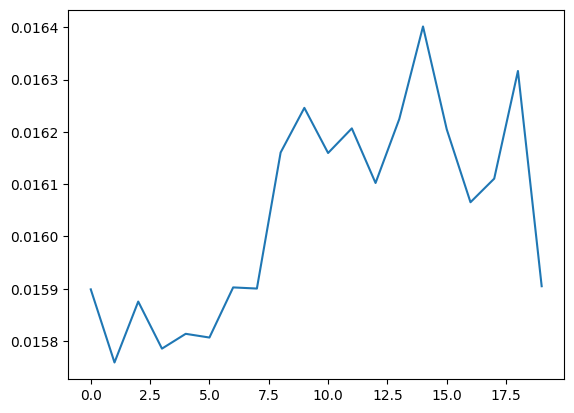

In [200]:

plt.plot(board.reward_history)

In [201]:
for _ in range(10):
    board.run_episode(seed=6787, display=True)

In [220]:
def main(display=True, record_video=False):
    pygame.init()
    DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)
    survival_areas =  [SurvivalArea(0, 0, 15, 15)]
    # survival_areas =  [SurvivalArea(0, 0, 15, 15), SurvivalArea(60, 0, 10, 10), SurvivalArea(0, 60, 10, 10), SurvivalArea(55, 55, 15, 15)]
    board = Board(70, 8, survival_areas)
    board.populate(200, device="cpu")

    
    

    # Game loop
    running = True


    # Record video
    # https://stackoverflow.com/questions/35097837/capture-video-data-from-screen-in-python
    # if record_video:
    #     output = "video.avi"
    #     img = pyautogui.screenshot()
    #     img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    #     #get info from img
    #     height, width, channels = img.shape
    #     # Define the codec and create VideoWriter object
    #     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #     out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))

    while running:
        episode = board.run_episode(display)
        board.natural_selection()

        # if record_video:
        #     try:
        #         img = pyautogui.screenshot()
        #         image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        #         out.write(image)
        #         StopIteration(0.5)
        #     except KeyboardInterrupt:
        #         break


    # if record_video:
    #     out.release()
    #     cv2.destroyAllWindows()

In [221]:
main(display=True)

C:\Users\kathe\AppData\Local\Temp\ipykernel_31984\1504175152.py:3: DeprecationWarning: The depth argument is deprecated, and is ignored
  DISPLAYSURF = pygame.display.set_mode((0, 0), pygame.FULLSCREEN, pygame.RESIZABLE)


average fitness: 0.0012075846613520866
average fitness: 0.0012425605868010602
average fitness: 0.0013650553446431257
average fitness: 0.00117759318375566
average fitness: 0.0019351935164521072
average fitness: 0.0010804178637616349
average fitness: 0.0007342492770215067
average fitness: 0.0009634004567922628
average fitness: 0.0012998372348505254
average fitness: 0.0010912104779348623
average fitness: 0.00114911576861618
average fitness: 0.006835497790930598
average fitness: 0.0017761425126101443
average fitness: 0.003406873392849607
average fitness: 0.0032103208598833737
average fitness: 0.0013147293623613776
average fitness: 0.003253793723520146
average fitness: 0.00225216495058003
average fitness: 0.001415918895963043


error: Surface is not initialized